In [1]:
%matplotlib inline


# Point source sensitivity

Estimate the CTA sensitivity for a point-like IRF at a fixed zenith angle and fixed offset.

## Introduction

This notebook explains how to estimate the CTA sensitivity for a
point-like IRF at a fixed zenith angle and fixed offset using the full
containment IRFs distributed for the CTA 1DC. The significance is
computed for a 1D analysis (On-OFF regions) and the LiMa formula.

We use here an approximate approach with an energy dependent integration
radius to take into account the variation of the PSF. We will first
determine the 1D IRFs including a containment correction.

We will be using the following Gammapy class:

-  `~gammapy.estimators.SensitivityEstimator`


In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

# %matplotlib inline
import matplotlib.pyplot as plt

## Setup

As usual, we’ll start with some setup …




In [3]:
from IPython.display import display
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import SensitivityEstimator
from gammapy.irf import load_cta_irfs
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom

## Check setup



In [4]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /home/savchenk/miniconda-recent/envs/gammapy-1.0.1/bin/python 
	python_version         : 3.9.16     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.0.1      
	path                   : /home/savchenk/miniconda-recent/envs/gammapy-1.0.1/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.24.2     
	scipy                  : 1.10.1     
	astropy                : 5.1.1      
	regions                : 0.7        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.7.0      
	jupyterlab             : 3.5.3      
	matplotlib             : 3.7.1      
	pandas                 : 1.5.2      
	healpy                 : 1.16.1     
	iminuit                : 2.20.0     
	sherpa                 : 4.15.0     
	naima                  : 0.10.0     
	emcee                  : 3.1.3      
	corner                 : 

## Define analysis region and energy binning

Here we assume a source at 0.5 degree from pointing position. We perform
a simple energy independent extraction for now with a radius of 0.1
degree.




In [5]:
energy_axis = MapAxis.from_energy_bounds("0.03 TeV", "30 TeV", nbin=20)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "100 TeV", nbin=100, name="energy_true"
)

geom = RegionGeom.create("icrs;circle(0, 0.5, 0.1)", axes=[energy_axis])

empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

## Load IRFs and prepare dataset

We extract the 1D IRFs from the full 3D IRFs provided by CTA.




In [6]:
irfs = load_cta_irfs(
    # "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    "./Prod5-South-20deg-SouthAz-14MSTs37SSTs.18000s-v0.1.fits.gz"
)
location = observatory_locations["cta_south"]
pointing = SkyCoord("0 deg", "0 deg")
obs = Observation.create(
    pointing=pointing, irfs=irfs, livetime="50 h", location=location
)

spectrum_maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])
dataset = spectrum_maker.run(empty_dataset, obs)

Now we correct for the energy dependent region size:




In [7]:
containment = 0.68

# correct exposure
dataset.exposure *= containment

# correct background estimation
on_radii = obs.psf.containment_radius(
    energy_true=energy_axis.center, offset=0.5 * u.deg, fraction=containment
)
factor = (1 - np.cos(on_radii)) / (1 - np.cos(geom.region.radius))
dataset.background *= factor.value.reshape((-1, 1, 1))

And finally define a `SpectrumDatasetOnOff` with an alpha of ``0.2``.
The off counts are created from the background model:




In [8]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)

## Compute sensitivity

We impose a minimal number of expected signal counts of 5 per bin and a
minimal significance of 3 per bin. We assume an alpha of 0.2 (ratio
between ON and OFF area). We then run the sensitivity estimator.




In [9]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=5, n_sigma=3, bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_on_off)

## Results

The results are given as an Astropy table. A column criterion allows to
distinguish bins where the significance is limited by the signal
statistical significance from bins where the sensitivity is limited by
the number of signal counts. This is visible in the plot below.




energy,e2dnde,excess,background,criterion
TeV,erg / (cm2 s),,,
float64,float64,float64,float64,bytes12
0.0356551,5.64402e-10,276.351,2763.51,bkg
0.0503641,1.7937e-11,154.672,1546.72,bkg
0.0711412,4.41506e-12,177.413,1774.13,bkg
0.10049,2.10662e-12,109.669,1071.5,significance
0.141945,1.66988e-12,67.6226,397.618,significance
0.200503,1.20765e-12,40.6525,137.714,significance
0.283218,8.60389e-13,26.3198,54.4013,significance
0.400056,6.77696e-13,18.0492,23.6309,significance


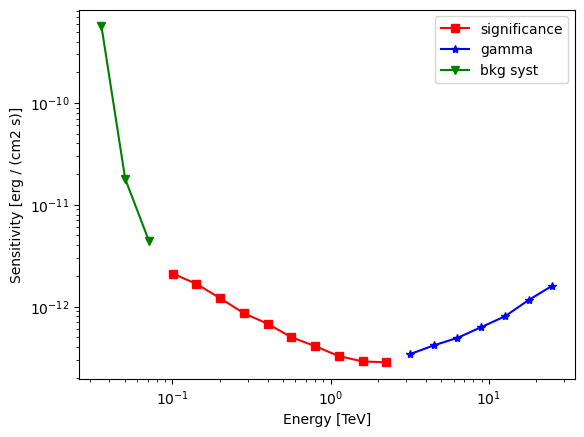

In [10]:
# Show the results table
display(sensitivity_table)

# Save it to file (could use e.g. format of CSV or ECSV or FITS)
# sensitivity_table.write('sensitivity.ecsv', format='ascii.ecsv')

# Plot the sensitivity curve
t = sensitivity_table

is_s = t["criterion"] == "significance"

fig, ax = plt.subplots()
ax.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s-",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
ax.plot(t["energy"][is_g], t["e2dnde"][is_g], "*-", color="blue", label="gamma")
is_bkg_syst = t["criterion"] == "bkg"
ax.plot(
    t["energy"][is_bkg_syst],
    t["e2dnde"][is_bkg_syst],
    "v-",
    color="green",
    label="bkg syst",
)

ax.loglog()
ax.set_xlabel(f"Energy [{t['energy'].unit}]")
ax.set_ylabel(f"Sensitivity [{t['e2dnde'].unit}]")
ax.legend()

We add some control plots showing the expected number of background
counts per bin and the ON region size cut (here the 68% containment
radius of the PSF).




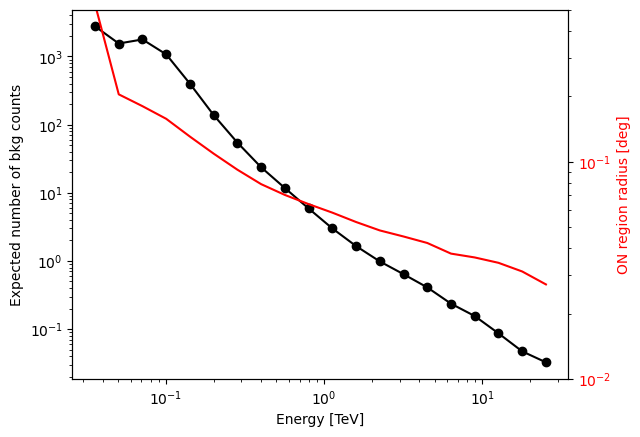

In [11]:
# Plot expected number of counts for signal and background
fig, ax1 = plt.subplots()
# ax1.plot( t["energy"], t["excess"],"o-", color="red", label="signal")
ax1.plot(t["energy"], t["background"], "o-", color="black", label="blackground")

ax1.loglog()
ax1.set_xlabel(f"Energy [{t['energy'].unit}]")
ax1.set_ylabel("Expected number of bkg counts")

ax2 = ax1.twinx()
ax2.set_ylabel(f"ON region radius [{on_radii.unit}]", color="red")
ax2.semilogy(t["energy"], on_radii, color="red", label="PSF68")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0.01, 0.5)
plt.show()

## Exercises

-  Also compute the sensitivity for a 20 hour observation
-  Compare how the sensitivity differs between 5 and 20 hours by
   plotting the ratio as a function of energy.


